In [6]:
from dotenv import load_dotenv
# from google import genai
# from google.genai import types
import google.generativeai as genai
from langsmith import traceable
import os

load_dotenv()

google_api_key = os.environ['GOOGLE_API_KEY']

genai.configure(
    api_key=google_api_key
)
# client = genai.Client(
#     api_key = google_api_key,
#     http_options = types.HttpOptions(api_version='v1alpha')
# )

# http_options = types.HttpOptions(
#     async_client_args
# )

# contents = types.Content(
#   role='user',
#   parts=[types.Part.from_text(text='Why is the sky blue?')]
# )

In [11]:
model = genai.GenerativeModel(
    model_name= 'gemini-2.0-flash-lite'
)

@traceable
def generate_with_gemini(prompt:str):
    response = model.generate_content(prompt)
    return response

res = generate_with_gemini('When is the Independant Day in USA?')

In [28]:
from langchain_community.tools import DuckDuckGoSearchRun

# DuckDuckGoSearchRun 인스턴스 생성
web_search = DuckDuckGoSearchRun()

query = "who is the mayor of NYC in 2025?"
search_result = web_search.invoke(query)

print("DuckDuckGo 검색 결과:", search_result)

DuckDuckGo 검색 결과: It's certainly an unusual New York City mayor's race. Spurred by a historic indictment of the sitting mayor, a long list of prominent Democrats started fundraising to see if they can topple incumbent Mayor Eric Adams in the June 24 Democratic primary. But in a stunning turn of events, Adams is ... The New York City mayoral race was already shaping up to be a campaign like no other — and then the incumbent ditched his party. The move came just after a federal judge dismissed Mayor Eric Adams' corruption case at the behest of the Trump administration, making Adams' most significant legal troubles disappear.. The next day, Adams declared that he would not be running as a Democrat for ... New York City, NYC Mayor Election Polls 2025: Incumbent Mayor Eric Adams is facing challenges, and with Andrew Cuomo officially entering the NYC mayoral race, his chances of reelection have weakened.Cuomo is currently leading in the polls and holds a higher favorability rating. The 2025 

In [29]:
from pprint import pprint
pprint(search_result)

("It's certainly an unusual New York City mayor's race. Spurred by a historic "
 'indictment of the sitting mayor, a long list of prominent Democrats started '
 'fundraising to see if they can topple incumbent Mayor Eric Adams in the June '
 '24 Democratic primary. But in a stunning turn of events, Adams is ... The '
 'New York City mayoral race was already shaping up to be a campaign like no '
 'other — and then the incumbent ditched his party. The move came just after a '
 "federal judge dismissed Mayor Eric Adams' corruption case at the behest of "
 "the Trump administration, making Adams' most significant legal troubles "
 'disappear.. The next day, Adams declared that he would not be running as a '
 'Democrat for ... New York City, NYC Mayor Election Polls 2025: Incumbent '
 'Mayor Eric Adams is facing challenges, and with Andrew Cuomo officially '
 'entering the NYC mayoral race, his chances of reelection have weakened.Cuomo '
 'is currently leading in the polls and holds a highe

In [78]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model = 'google_genai:gemini-2.0-flash-lite',
    tools = [web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [79]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [80]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "who is the mayor of NYC?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  duckduckgo_search (56035f4f-6ffc-4ec2-b571-7e7909300b6e)
 Call ID: 56035f4f-6ffc-4ec2-b571-7e7909300b6e
  Args:
    query: who is the mayor of NYC?


Update from node tools:


================================= Tool Message =================================
Name: duckduckgo_search

Four years ago, New Yorkers for the first time voted for the next mayor of the city using ranked choice. But soon after releasing preliminary results, the elections board announced that it had incorrectly included in those results 135,000 test ballots. The debacle threw the mayor's race into limbo. The New York City primary election is June 24, with early voting open until June 22. Eleven Democrats are running for mayor, including Adrienne E. Adams and Andrew M. Cuomo. Unofficial, first ... New York City Public Advocate Jumaane Williams is next in the line of succession

In [81]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b

In [82]:
math_agent = create_react_agent(
    model = 'google_genai:gemini-2.0-flash',
    tools = [add, multiply, divide],
    prompt = (
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name = 'math_agent'
)

In [83]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (2237f61b-f4fa-49ce-ad74-bbfb01ea465a)
 Call ID: 2237f61b-f4fa-49ce-ad74-bbfb01ea465a
  Args:
    a: 3.0
    b: 5.0


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (022f19e8-ec9e-47d7-bdef-22e45cf10268)
 Call ID: 022f19e8-ec9e-47d7-bdef-22e45cf10268
  Args:
    a: 8.0
    b: 7.0


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




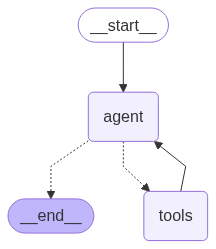

In [84]:
from IPython.display import Image, display


Image(math_agent.get_graph().draw_mermaid_png())

In [85]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model = init_chat_model('google_genai:gemini-2.0-flash'),
    agents = [research_agent, math_agent],
    prompt = (
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages = True,
    output_mode = 'full_history'
).compile()

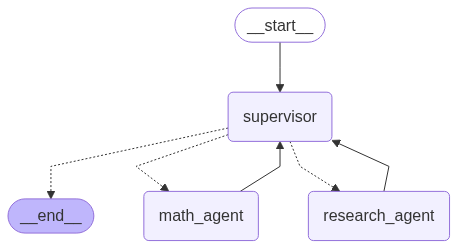

In [86]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [88]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "2024년 미국의 GDP와 뉴욕시의 GDP가 어떻게 되고, 뉴욕시 GDP는 미국 GDP의 몇 퍼센트를 차지하고 있어?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

I couldn't find the exact GDP for New York City in 2024. However, I can estimate the percentage if you provide me with an estimate for New York City's 2024 GDP. Would you like me to proceed with an estimation if you can find a number?




In [89]:
final_message_history = chunk["supervisor"]["messages"]

In [90]:
final_message_history

[HumanMessage(content='2024년 미국의 GDP와 뉴욕시의 GDP가 어떻게 되고, 뉴욕시 GDP는 미국 GDP의 몇 퍼센트를 차지하고 있어?', additional_kwargs={}, response_metadata={}, id='ce0796bb-d172-44f3-a8f8-03096224132e'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_research_agent', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, name='supervisor', id='run--ed4d7241-de53-4d62-8e1e-cd564b875678-0', tool_calls=[{'name': 'transfer_to_research_agent', 'args': {}, 'id': 'e48d2bd8-9c69-475e-8429-7938ffde64d5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 134, 'output_tokens': 7, 'total_tokens': 141, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='Successfully transferred to research_agent', name='transfer_to_research_agent', id='393a9a19-4d69-4051-a0e6-0398558baf79', tool_call_id='e48d2bd8-9c69-475e-8429-7938ffde64d5'), AIMessage(content='

In [91]:
for m in final_message_history:
    pretty_print_message(m)

================================ Human Message =================================

2024년 미국의 GDP와 뉴욕시의 GDP가 어떻게 되고, 뉴욕시 GDP는 미국 GDP의 몇 퍼센트를 차지하고 있어?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (e48d2bd8-9c69-475e-8429-7938ffde64d5)
 Call ID: e48d2bd8-9c69-475e-8429-7938ffde64d5
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  duckduckgo_search (79d17836-e2ae-456e-ad4f-6717735b281f)
 Call ID: 79d17836-e2ae-456e-ad4f-6717735b281f
  Args:
    query: 2024 US GDP
  duckduckgo_search (b2d68cda-7c01-41a3-a19e-db051742a447)
 Call ID: b2d68cda-7c01-41a3-a19e-db051742a447
  Args:
    query: 2024 New York City GDP
================================= Tool Message ===============

In [95]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command

In [96]:
def create_handoff_tool(*, agent_name:str, description:str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} fro help."

    @tool(name, description=description)
    def handoff_tool(
        state : Annotated[MessagesState, InjectedState],
        tool_call_id : Annotated[str, InjectedToolCallId]
    ) -> Command:
        tool_message = {
            "role" : "tool",
            "content" : f"Successfully transferred to {agent_name}",
            "name" : name,
            "tool_call_id" : tool_call_id,
        }
        return Command(
            goto = agent_name,
            update = {**state, "messages" : state["messages"] + [tool_message]},
            graph=Command.PARENT
        )

    return handoff_tool

assign_to_research_agent = create_handoff_tool(
    agent_name = "research_agent",
    description="Assign task to a researcher agent."
)

assign_to_math_agent = create_handoff_tool(
    agent_name = "math_agent",
    description = "Assign task to a math agent"
)

In [97]:
supervisor_agent = create_react_agent(
    model='google_genai:gemini-2.0-flash',
    tools = [assign_to_research_agent, assign_to_math_agent],
    prompt = (
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name = "supervisor",
)

In [105]:
from langgraph.graph import END

workflow = StateGraph(MessagesState)
workflow.add_node(supervisor_agent, destinations=["research_agent", "math_agent"])
workflow.add_node(research_agent)
workflow.add_node(math_agent)
workflow.add_edge(START, 'supervisor')
workflow.add_edge('research_agent', 'supervisor')
workflow.add_edge('math_agent', 'supervisor')
supervisor = workflow.compile()

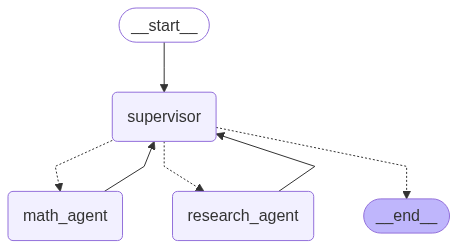

In [108]:
Image(supervisor.get_graph().draw_mermaid_png())

In [109]:
for chunk in supervisor.stream(
    {
        "messages" : [
            {
                "role" : "user",
                "content" : "find US and New York state GDP in 2024. what % of US GDP was New York state?"
            }
        ]
    }
):
    pretty_print_messages(chunk, last_message = True)

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

I am sorry, I cannot provide the exact GDP for the US and New York state for 2024. The search results provide the US GDP growth rate for the fourth quarter of 2024 and mention the New York state GDP, but do not provide the specific values needed to calculate the percentage.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================== Ai Message ==================================
Name: math_agent

I am designed to assist with math-related tasks only.


Update from node supervis

In [117]:
final_message_history = chunk['supervisor']['messages']

In [118]:
for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

find US and New York state GDP in 2024. what % of US GDP was New York state?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (668aeae4-c378-461f-a75b-cb9b2af3262e)
 Call ID: 668aeae4-c378-461f-a75b-cb9b2af3262e
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  duckduckgo_search (98a7a6e2-8a75-4214-83bd-a5e663bae3db)
 Call ID: 98a7a6e2-8a75-4214-83bd-a5e663bae3db
  Args:
    query: US GDP 2024
  duckduckgo_search (db8c0479-07e2-481e-a8e6-8819fd015976)
 Call ID: db8c0479-07e2-481e-a8e6-8819fd015976
  Args:
    query: New York state GDP 2024
================================= Tool Message ===

In [121]:
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool

In [135]:
assign_to_research_agent_with_description = create_task_description_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent_with_description = create_task_description_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

In [140]:
assign_to_research_agent_with_description(
    {"task_descripton" : "Search USA GDP in Internet"}
)

ValidationError: 2 validation errors for transfer_to_research_agent
task_description
  Field required [type=missing, input_value={'task_descripton': 'Search USA GDP in Internet'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
state
  Field required [type=missing, input_value={'task_descripton': 'Search USA GDP in Internet'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

In [124]:
supervisor_agent_with_description = create_react_agent(
    model="google_genai:gemini-2.0-flash",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this assistant\n"
        "- a math agent. Assign math-related tasks to this assistant\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    name="supervisor",
)

In [126]:
supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

In [127]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (d7ecc139-2e65-4dc8-9b63-c9d4c9948f34)
	 Call ID: d7ecc139-2e65-4dc8-9b63-c9d4c9948f34
	  Args:


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  duckduckgo_search (ceb7d862-fbbc-40b7-b84e-2828e243b9bc)
	 Call ID: ceb7d862-fbbc-40b7-b84e-2828e243b9bc
	  Args:
	    query: US GDP 2024
	  duckduckgo_search (1528134a-7f3c-46af-bfc7-248606f065db)
	 Call ID: 1528134a-7f3c-46af-bfc7-248606f065db
	  Args:
	    query: New York state GDP 2024


Update from subgraph research_agent:


	Update from node tools:


	================================= Tool Message =================================
	Name: duckduckgo_search
	
	Real gross domestic product (GDP) increase

In [131]:
_, real_chunk = chunk

In [133]:
final_message_history = real_chunk['supervisor']['messages']

for message in final_message_history:
    message.pretty_print()

================================ Human Message =================================

find US and New York state GDP in 2024. what % of US GDP was New York state?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_agent (d7ecc139-2e65-4dc8-9b63-c9d4c9948f34)
 Call ID: d7ecc139-2e65-4dc8-9b63-c9d4c9948f34
  Args:
================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent
================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  duckduckgo_search (ceb7d862-fbbc-40b7-b84e-2828e243b9bc)
 Call ID: ceb7d862-fbbc-40b7-b84e-2828e243b9bc
  Args:
    query: US GDP 2024
  duckduckgo_search (1528134a-7f3c-46af-bfc7-248606f065db)
 Call ID: 1528134a-7f3c-46af-bfc7-248606f065db
  Args:
    query: New York state GDP 2024
================================= Tool Message ===

In [146]:
p = """사용 가능한 툴:
- transfer_to_research_agent(task_description: str): Description of what the next agent should do, including all of the relevant context.

사용자 질문: "2024년 미국과 뉴욕주 GDP를 찾아서 비율을 계산해줘."
..."""

print(p)

사용 가능한 툴:
- transfer_to_research_agent(task_description: str): Description of what the next agent should do, including all of the relevant context.

사용자 질문: "2024년 미국과 뉴욕주 GDP를 찾아서 비율을 계산해줘."
...
